# Séries temporais com a biblioteca *Darts*

Uma biblioteca pouco conhecida, porém muito interessante é a *Darts* que tem como finalidade aplicar modelos de séries temporais de forma fácil e intuitiva. Há vários modelos de séries temporais que podem ser utilizados, mas nesse projeto em particular irei utilizar os modelos de Suavização Exponencial, o *Facebook Prophet*, *FFT* e *Four Theta*.

## Dados

A base de dados é uma série temporal de vendas em restaurantes que possui periodicidade mensal e pode ser obtida nesse [link](https://fred.stlouisfed.org/series/MRTSSM7225USN), que vai direto para o *site* do *FRED* que é uma base de dados do *Federal Reserve Board*. A série se inicia em Janeiro de 1992 e vai até Janeiro de 2020, totalizando cerca de 337 meses e a unidade de medida da série está em milhões de dólares americanos (*USD*).

## Instalando a biblioteca *DARTS*

In [ ]:
pip install 'u8darts[all]'

     |████████████████████████████████| 143kB 5.0MB/s 
     |████████████████████████████████| 25.9MB 177kB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 788kB 44.8MB/s 
     |████████████████████████████████| 112kB 47.9MB/s 
     |████████████████████████████████| 6.8MB 43.0MB/s 
     |████████████████████████████████| 14.6MB 191kB/s 
     |████████████████████████████████| 8.7MB 31.9MB/s 
     |████████████████████████████████| 10.5MB 18.3MB/s 
     |████████████████████████████████| 1.5MB 40.5MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 10.6MB 20.5MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 368kB 44.7MB/s 
     |████████████████████████████████| 2.1MB 36.6MB/s 
  Created wheel for holidays: filename=holidays-0.10.2-cp36-none-any.whl size=111560 sha256=b89aaf2f3c9474fdfe064c9d9b41f57247d3c092a65c7c3a69a3a26a54196dd6
  Stor

## Importando as bibliotecas

Irei importar as bibliotecas padrões para análise de dados, que são o *Pandas*, *Numpy*, *Matplotlib* e *Seaborn*. Da biblioteca *DARTS* irei importar o módulo que transforma a base de dados em um objeto *TimeSeries*, os modelos de séries temporais e as métricas de avaliação.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.utils.statistics import remove_seasonality, remove_trend
from darts.models import ExponentialSmoothing, FFT, Theta, Prophet, FourTheta
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode
from darts.metrics import mape, mase, coefficient_of_variation, mae, marre, mse, ope, r2_score, rmse, rmsle, smape
from darts.utils.statistics import plot_residuals_analysis
from tabulate import tabulate

## Importando a base de dados

In [ ]:
df = pd.read_csv('MRTSSM7225USN.csv')

## Explorando a base de dados

Primeiras e últimas observações da base de dados. Se compararmos o início da série com o seu final, vemos que houve um aumento médio de quase 4 vezes o valor em relação ao valor inicial.

In [ ]:
display(df.head())
display(df.tail())

,DATE,MRTSSM7225USN
0,1992-01-01,13325
1,1992-02-01,13474
2,1992-03-01,14346
3,1992-04-01,14065
4,1992-05-01,15077


,DATE,MRTSSM7225USN
332,2019-09-01,53944
333,2019-10-01,55762
334,2019-11-01,54039
335,2019-12-01,57086
336,2020-01-01,53411


Dimensão da base de dados: temos duas colunas com 337 observações.

In [ ]:
df.shape

(337, 2)

Tabela estatística da base de dados apresentando a média, desvio padrão, os valores mínimos e máximos, e, por fim, os quartis da série.

In [ ]:
df.describe()

,MRTSSM7225USN
count,337.000000
mean,30624.605341
std,12124.449416
min,13325.000000
25%,20153.000000
50%,29239.000000
75%,38926.000000
max,59318.000000


Informações sobre a base de dados.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DATE           337 non-null    object
 1   MRTSSM7225USN  337 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


Não há valores faltantes na base de dados.

In [ ]:
df.isna().sum()

DATE             0
MRTSSM7225USN    0
dtype: int64

Abaixo, podemos ver o histograma da série de dados e que o mesmo não apresenta um comportamento de uma distribuição, que possui o formato de sino (*bell curve*).

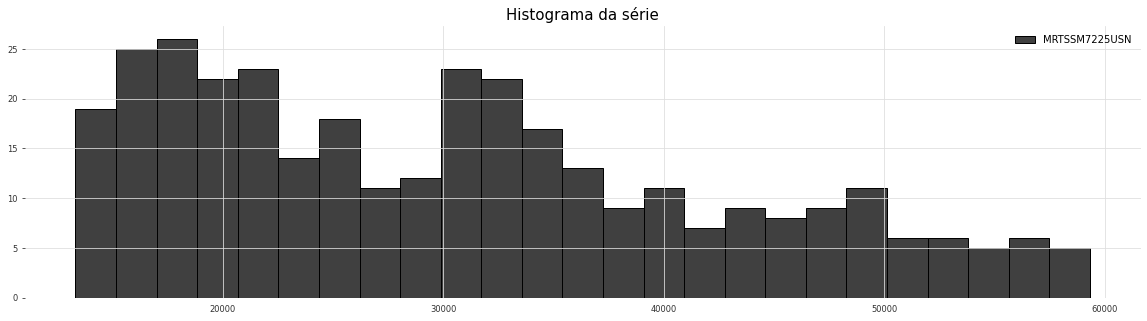

In [ ]:
plt.figure(figsize=(20,5))
sns.histplot(df, bins=25)
plt.title('Histograma da série',size=15)
plt.xlabel('')
plt.ylabel('')
plt.show()

Convertendo a base de dados para um objeto *TimeSeries*, formato de trabalho da biblioteca *darts*.

In [ ]:
series = TimeSeries.from_dataframe(df, 'DATE', ['MRTSSM7225USN'])

Plotando a base de dados percebemos a presença do componente sazonal que vai se destacando com o tempo. Nos primeiro anos a sazonalidade não era tão forte, porém do meio da série em diante começa a se destacar mais. Além disso, a presença de uma tendência global da série, que teve um breve interrupção a partir do ano de 2009 (provavelmente por conta da crise econômica desse ano).

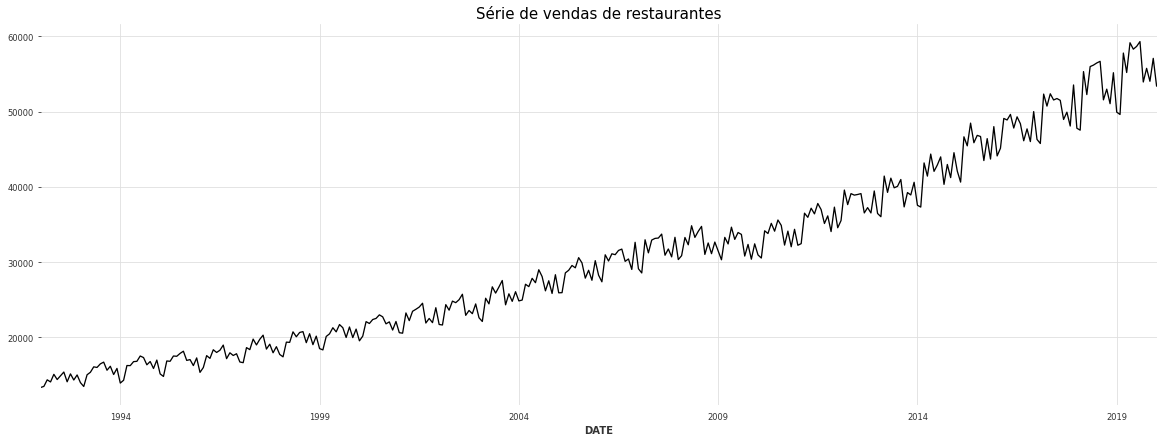

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Série de vendas de restaurantes', size=15)
series.plot()

Podemos remover os componentes dessa série, removendo apenas a sazonalidade ou a tendência ou esses dois componentes simultaneamente.

In [ ]:
#removendo a sazonalidade
remove_sazon = remove_seasonality(series,freq=12)
#removendo a tendência
remove_tend = remove_trend(series)
#removendo sazonalidade e tendência
remove_tend_sazon = remove_trend(remove_sazon)

Plotando a série com a sazonalidade removida.

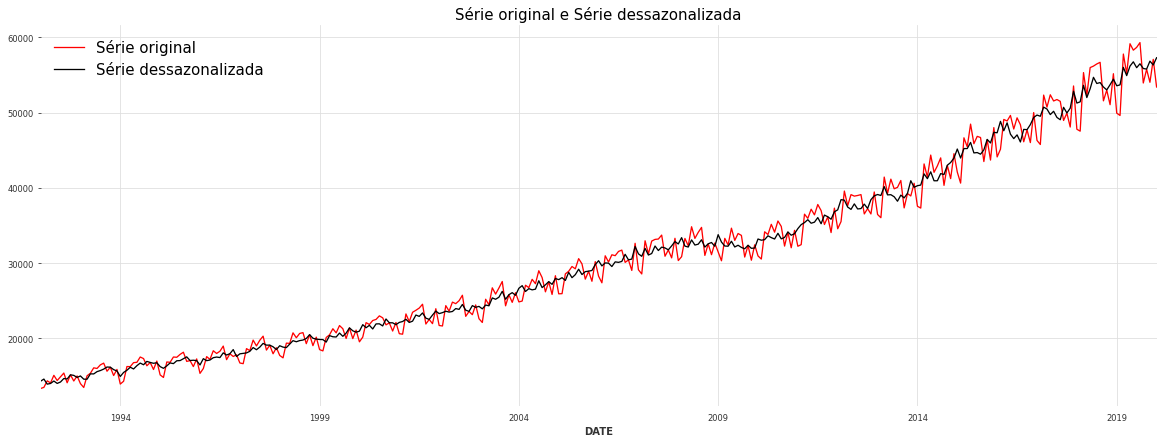

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Série original e Série dessazonalizada',size=15)
series.plot(color='red', label = 'Série original')
remove_sazon.plot(label = 'Série dessazonalizada')
plt.legend(fontsize=15);

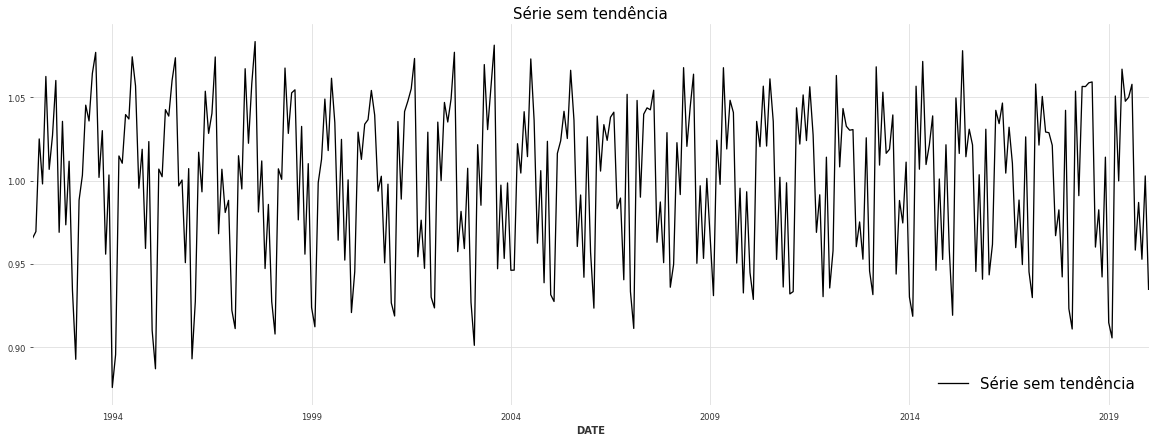

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Série sem tendência',size=15)
remove_tend.plot(label = 'Série sem tendência')
plt.legend(fontsize=15);

Plotando a série sem a tendência e sem a sazonalidade. Praticamente o que é plotando abaixo pode ser um componente cíclico ou apenas um comportamento aleatório da série.

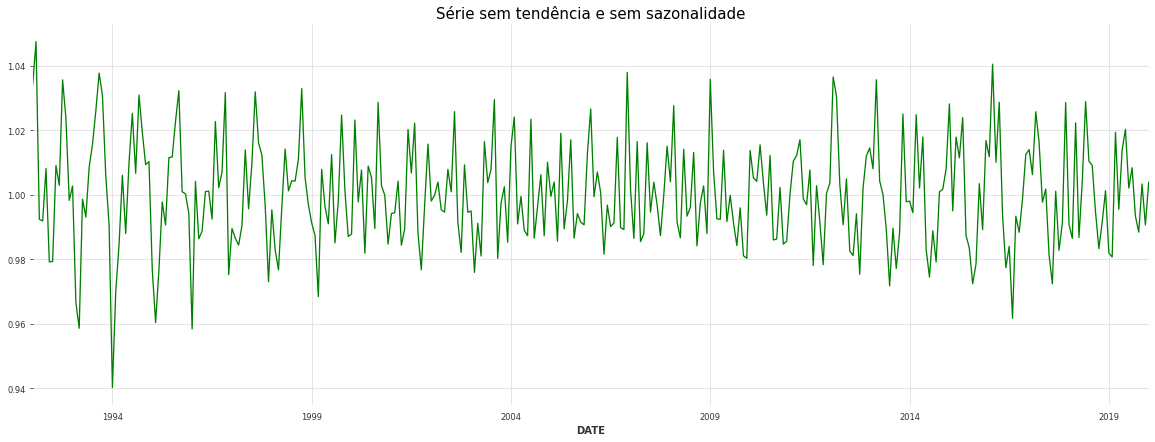

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Série sem tendência e sem sazonalidade',size=15)
#series.plot(color='red', label = 'Série original')
remove_tend_sazon.plot(color='green');
#plt.legend(fontsize=15);

## Separando dados de treino e de validação

A base de treino será a que será usada para treinar o modelo e a base de validação é a base de dados que o modelo não *verá* e será usada para comparar o desempenho das previsões geradas pelo(s) modelo(s) usado(s).

De forma arbitrária definirei que a série de treino irá até Janeiro de 2016 e a base de validação será o restante da série original.

In [ ]:
train, val = series.split_before(pd.Timestamp('2016-02-01'))

Base de treino.

In [ ]:
train

            MRTSSM7225USN
DATE                     
1992-01-01          13325
1992-02-01          13474
1992-03-01          14346
1992-04-01          14065
1992-05-01          15077
...                   ...
2015-09-01          43500
2015-10-01          46417
2015-11-01          43697
2015-12-01          48011
2016-01-01          44115

[289 rows x 1 columns]
Freq: MS

Base de valiação.

In [ ]:
val

            MRTSSM7225USN
DATE                     
2016-02-01          45139
2016-03-01          49100
2016-04-01          48893
2016-05-01          49634
2016-06-01          47822
2016-07-01          49313
2016-08-01          48397
2016-09-01          46129
2016-10-01          47710
2016-11-01          46022
2016-12-01          50012
2017-01-01          46310
2017-02-01          45767
2017-03-01          52336
2017-04-01          50738
2017-05-01          52376
2017-06-01          51553
2017-07-01          51746
2017-08-01          51505
2017-09-01          48963
2017-10-01          49932
2017-11-01          48090
2017-12-01          53549
2018-01-01          47797
2018-02-01          47540
2018-03-01          55328
2018-04-01          52271
2018-05-01          55993
2018-06-01          56191
2018-07-01          56477
2018-08-01          56692
2018-09-01          51571
2018-10-01          52993
2018-11-01          51060
2018-12-01          55178
2019-01-01          49940
2019-02-01  

Plotando novamente a série total, podemos ver destacado de cores diferentes a base de treino e a base de validação.

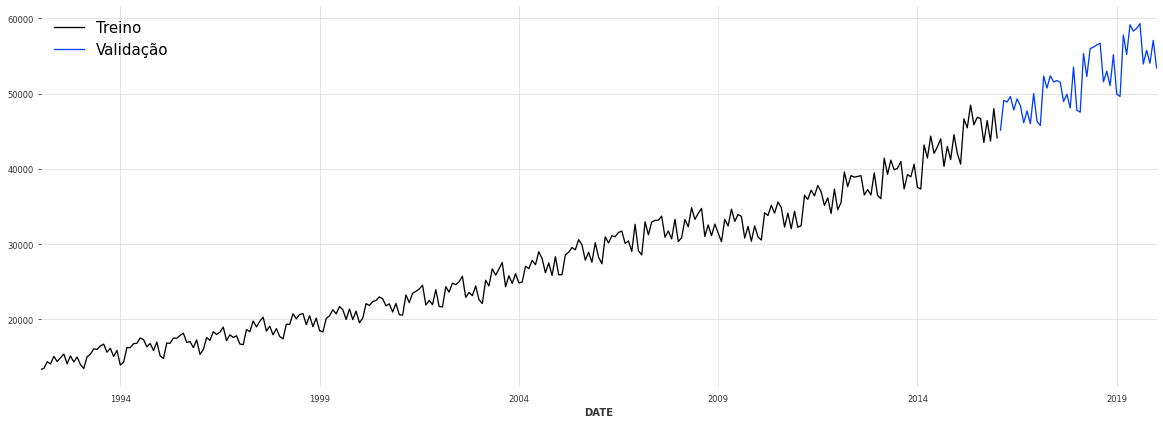

In [ ]:
plt.figure(figsize=(20,7))
train.plot(label = 'Treino')
val.plot(label='Validação')
plt.legend(fontsize=15);

## Aplicando a Suavização Exponencial

O método de suavização expoencial é uma forma de modelagem de séries temporais em que não aplicação probabilística, os resultados gerados são calculados com base nas observações anteriores, havendo apenas um mecanismo de correção de erros. Existem vários tipos de suavização, como a **Simples**, **Holt**, **Holt-Winter** e **Pegels**. Aqui não precisaremos realizar nenhum teste estatístico para definir quais as defasagens mais importantes ou para definir algum conjunto de parâmetros.

Vamos então criar, treinar e gerar previsões com o modelo de **Suavização Exponencial**.

In [ ]:
#Instanciando o modelo em uma variável
model1 = ExponentialSmoothing()
#treinando o modelo
model1.fit(train)
#gerando as previsões e atribuindo uma variável para elas
prediction1 = model1.predict(len(val))

Imprimindo o modelo.

In [ ]:
print(model1)

Exponential smoothing


Plotando as previsões com a séries de validação.

Visualmente as previsões geradas pelo modelo de **Suavização Exponencial** acompanham bem a base de dados de validação.

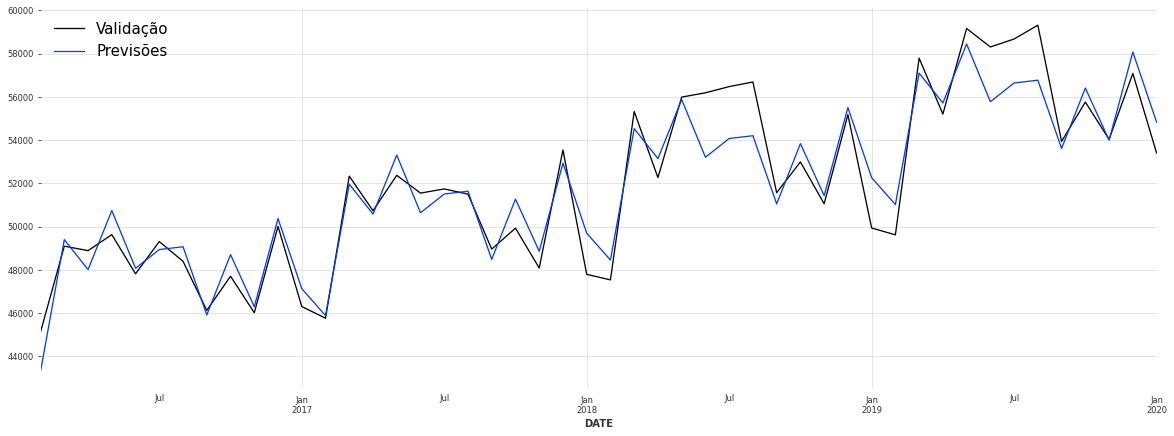

In [ ]:
plt.figure(figsize=(20,7))
#train.plot(label='Treino')
val.plot(label='Validação')
prediction1.plot(label='Previsões')
plt.legend(fontsize=15);

Não basta verificar visualmente os resultados, por isso utilizamos métricas de avaliação que foram importadas anteriormente. O objetivo será comparar os resultados dessas métricas com as de outros modelos.

Métricas de avaliação do modelo de Suavização Exponencial.

In [ ]:
print(tabulate([['Erro médio Absoluto percentual :', mape(prediction1, val)], 
                ['Coeficiente de variação :', coefficient_of_variation(prediction1, val)],
                ['Erro médio absoluto em escala :', mase(prediction1, val,insample = train)], 
                ['Erro médio absoluto :', mae(prediction1, val)],
                ['Erro médio quadrado :', mse(prediction1, val)],
                ['Raiz do erro médio quadrado :', rmse(prediction1, val)],
                ['Coeficiente de determinação R-Squared :', r2_score(prediction1, val)],
                ['Raiz do erro de log do quadrado médio :', rmsle(prediction1, val)],
                ['Erro percentual médio absoluto simétrico :', smape(prediction1, val)],
                ['Erro de porcentagem geral :', ope(prediction1, val)],
                ['Erro médio absoluto de alcance relativo :', marre(prediction1, val)]],     
               headers=['Métrica do modelo de Suavização Exponencial', 'Valor']))

Métrica do modelo de Suavização Exponencial             Valor
---------------------------------------------  --------------
Erro médio Absoluto percentual :                  1.78747
Coeficiente de variação :                         2.3298
Erro médio absoluto em escala :                   0.699859
Erro médio absoluto :                           934.696
Erro médio quadrado :                             1.45938e+06
Raiz do erro médio quadrado :                  1208.05
Coeficiente de determinação R-Squared :           0.880373
Raiz do erro de log do quadrado médio :           0.0227252
Erro percentual médio absoluto simétrico :        1.78083
Erro de porcentagem geral :                       0.141111
Erro médio absoluto de alcance relativo :         6.18005


Além de analisar o desempenho do modelo com as métricas de avaliação, podemos simular como o modelo teria se desempenhado se tivesse sido historicamente usado para prever a série temporal.

In [ ]:
forecast = model1.historical_forecasts(series, start=0.5, forecast_horizon=12, stride=6, last_points_only=False)

Plotando os resultados vemos de vermelho a série se o modelo fosse usado historicamente para realizar previsões e, visualmente, parece gerar bons resultados.

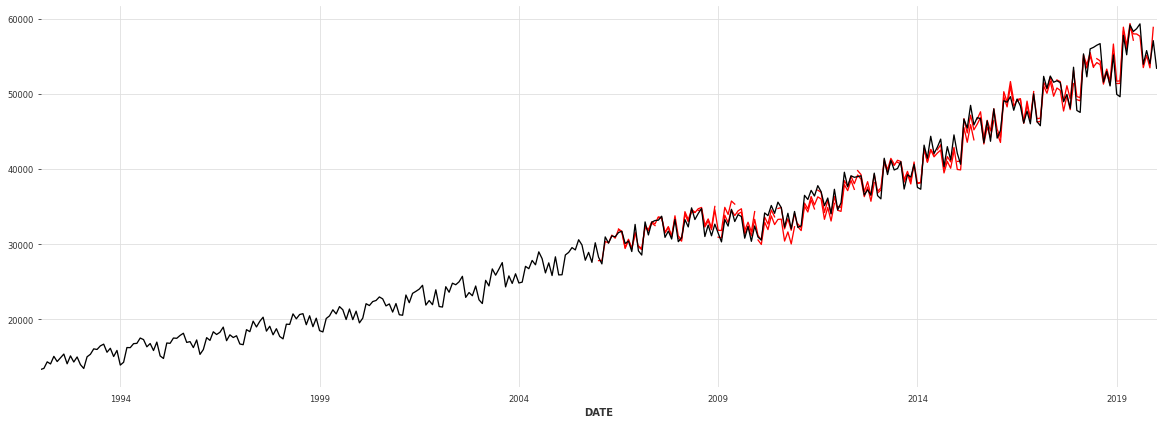

In [ ]:
plt.figure(figsize=(20,7))
for i in range(0,27):
  forecast[i].plot(color='red')
series.plot(color='black')

E podemos avaliar o desempenho do modelo em relação a todas as previsões que ele produz.

In [ ]:
backtest_erros = model1.backtest(series, start=0.5, forecast_horizon=12, stride=1, last_points_only=False, metric=mape, reduction=None)

E assim gerar o histograma desses erros históricos.

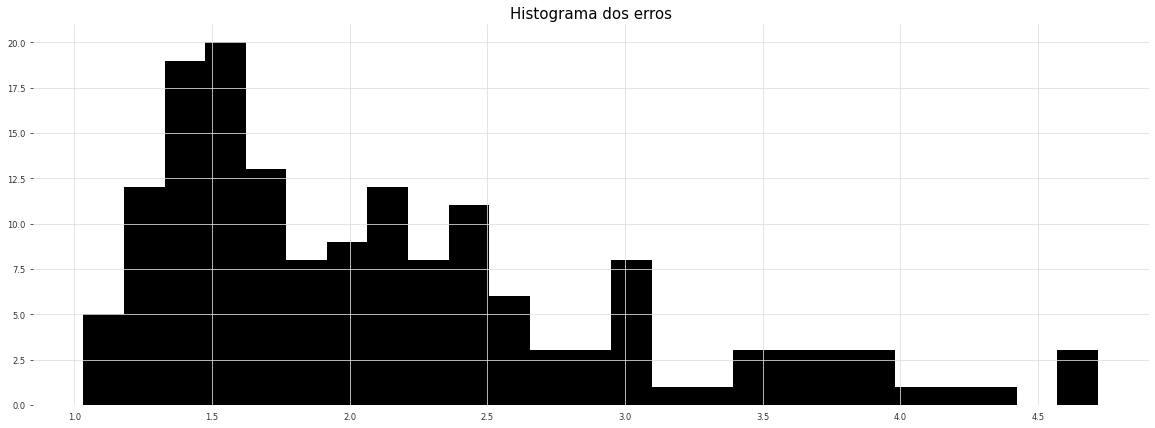

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Histograma dos erros', size=15)
plt.hist(backtest_erros, bins=25);

Análise dos resíduos totais da série.

Podemos ver que o modelo gerou resíduos com comportamento normal, que pode ser visto pelo histograma.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimizati

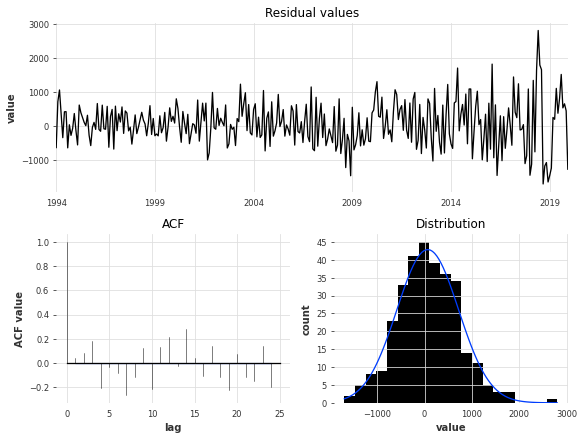

In [ ]:
plot_residuals_analysis(model1.residuals(series))

Agora realizarei os mesmos procedimentos para outros modelos e comparar os resultados.

## Aplicando o modelo *Prophet*

O próximo modelo que irei utilizar é o *Facebook Prophet* que foi desenvolvido pela empresa *Facebook* para profissionais que necessitassem trabalhar com esse tipo de dado, mas não fosse familiarizados com a teoria estatística utilizada para modelagem. Também, por isso o *Facebook Prophet* funciona como uma *black box*, pois o resultado é gerado, mas não sabe-se ao certo como foi gerado.

Agora vamos criar e treinar o modelo, e gerar as previsões. Para o modelo *Prophet* eu irei definir de forma arbitrária uma frequência de 12 períodos (meses) para a sazonalidade.

In [ ]:
#Instanciando o modelo em uma variável
model2 = Prophet(frequency=12)
#treinando o modelo
model2.fit(train)
#gerando as previsões e atribuindo uma variável para elas
prediction2 = model2.predict(len(val))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Imprimindo o modelo.

In [ ]:
print(model2)

Prophet


Plotando as previsões e os valores reais vemos que o desempenho ficou aquém, comparado ao modelo de Suavização Exponencial.

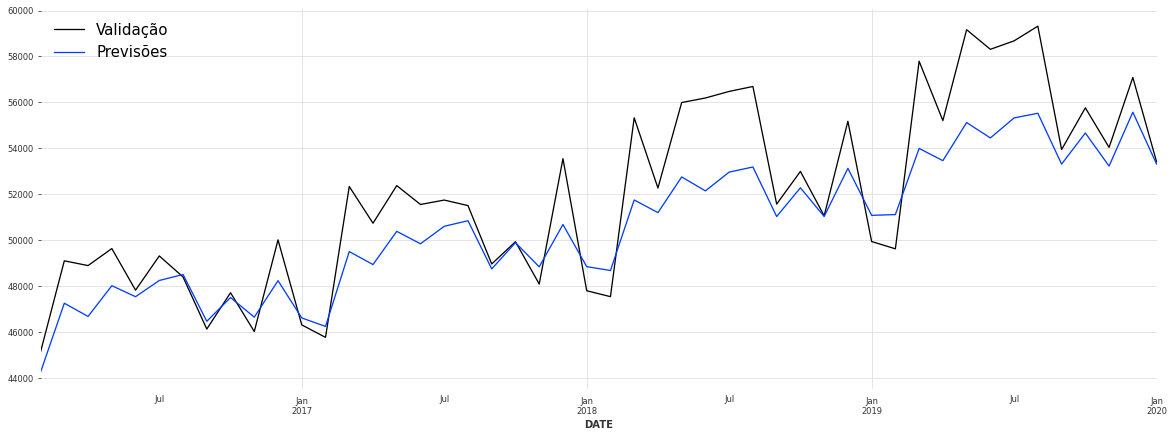

In [ ]:
plt.figure(figsize=(20,7))
#train.plot(label='Treino')
val.plot(label='Validação')
prediction2.plot(label='Previsões')
plt.legend(fontsize=15);

A métricas de avaliação do modelo *Prophet* mostraram um desempenho pior.

In [ ]:
print(tabulate([['Erro médio Absoluto percentual :', mape(prediction2, val)], 
                ['Coeficiente de variação :', coefficient_of_variation(prediction2, val)],
                ['Erro médio absoluto em escala :', mase(prediction2, val,insample = train)], 
                ['Erro médio absoluto :', mae(prediction2, val)],
                ['Erro médio quadrado :', mse(prediction2, val)],
                ['Raiz do erro médio quadrado :', rmse(prediction2, val)],
                ['Coeficiente de determinação R-Squared :', r2_score(prediction2, val)],
                ['Raiz do erro de log do quadrado médio :', rmsle(prediction2, val)],
                ['Erro percentual médio absoluto simétrico :', smape(prediction2, val)],
                ['Erro de porcentagem geral :', ope(prediction2, val)],
                ['Erro médio absoluto de alcance relativo :', marre(prediction2, val)]],     
               headers=['Métrica do modelo Prophet', 'Valor']))

Métrica do modelo Prophet                            Valor
------------------------------------------  --------------
Erro médio Absoluto percentual :               3.13188
Coeficiente de variação :                      4.04272
Erro médio absoluto em escala :                1.21071
Erro médio absoluto :                       1616.96
Erro médio quadrado :                          4.18737e+06
Raiz do erro médio quadrado :               2046.31
Coeficiente de determinação R-Squared :        0.484036
Raiz do erro de log do quadrado médio :        0.0380209
Erro percentual médio absoluto simétrico :     3.0639
Erro de porcentagem geral :                    2.58397
Erro médio absoluto de alcance relativo :     14.2862


Vamos ver o desempenho histórico do modelo.

In [ ]:
forecast2 = model2.historical_forecasts(series, start=0.5, forecast_horizon=12, stride=6, last_points_only=False)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

E agora, plotando os resultados vemos que considerando a tendência o modelo performou bem, mas não conseguiu captar a sazonalidade da série, como o modelo de Suavização Exponencial.

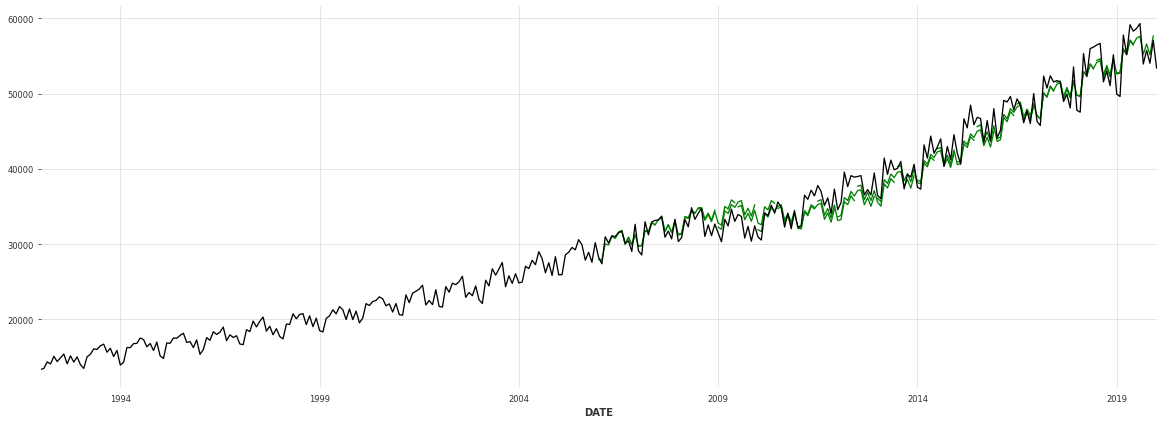

In [ ]:
plt.figure(figsize=(20,7))
for i in range(0,27):
  forecast2[i].plot(color='green')
series.plot(color='black')

Analisando os erros.

In [ ]:
backtest_erros2 = model2.backtest(series, start=0.5, forecast_horizon=12, stride=1, last_points_only=False, metric=mape, reduction=None)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Plotando o histograma.

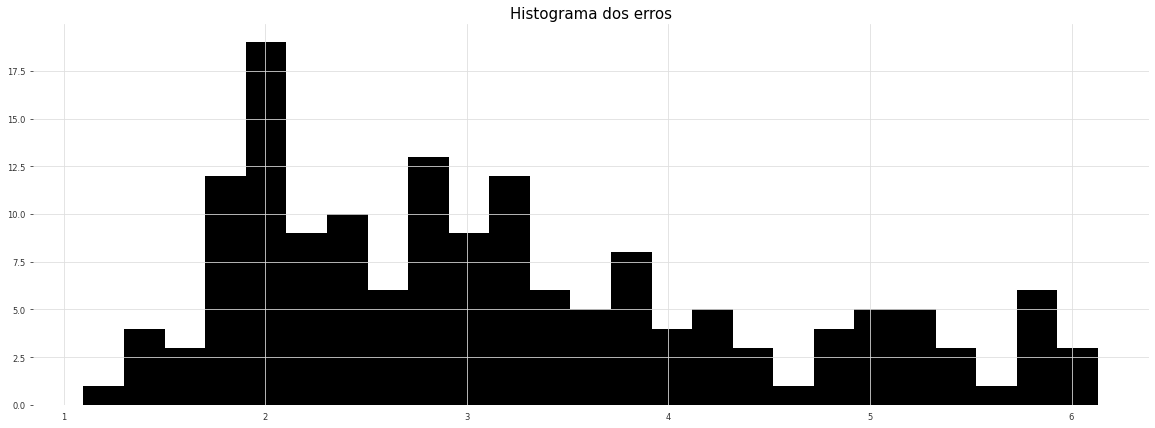

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Histograma dos erros', size=15)
plt.hist(backtest_erros2, bins=25);

Na análise dos resíduos do *Prophet*, vemos que o desempenho não foi interessante.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disab

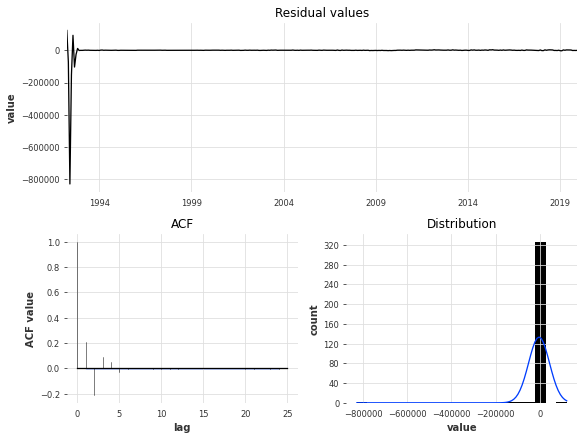

In [ ]:
plot_residuals_analysis(model2.residuals(series))

Até o momento o melhor modelo é o de Suavização Exponencial.

## Aplicando o modelo *FFT*

Transformada rápida de Fourier é um algoritmo muito usado para modelagem de séries temporais, principalmente para detecção de comportamentos periódicos. Para esse algoritmo definirei a tendência como polinomial de terceiro grau e número de frequências para previsão serão 12.

In [ ]:
#Instanciando o modelo em uma variável
model3 = FFT(trend='poly', nr_freqs_to_keep=12, required_matches=set(), trend_poly_degree=3)
#treinando o modelo
model3.fit(train)
#gerando as previsões e atribuindo uma variável para elas
prediction3 = model3.predict(len(val))

Imprimindo o modelo.

In [ ]:
print(model3)

FFT(nr_freqs_to_keep=12, trend=poly)


Visualizando os valores previstos e reais.

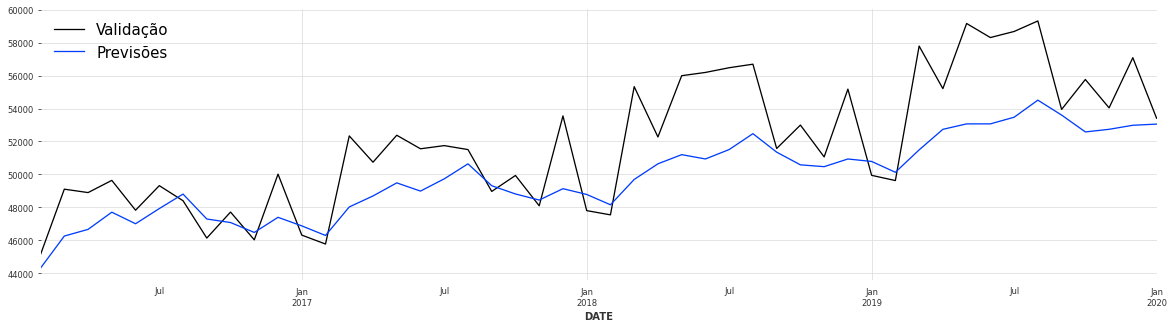

In [ ]:
plt.figure(figsize=(20,5))
#train.plot(label='Treino')
val.plot(label='Validação')
prediction3.plot(label='Previsões')
plt.legend(fontsize=15);

Métricas de avaliação da Tranformada Rápida de Fourier.

In [ ]:
print(tabulate([['Erro médio Absoluto percentual :', mape(prediction3, val)], 
                ['Coeficiente de variação :', coefficient_of_variation(prediction3, val)],
                ['Erro médio absoluto em escala :', mase(prediction3, val,insample = train)], 
                ['Erro médio absoluto :', mae(prediction3, val)],
                ['Erro médio quadrado :', mse(prediction3, val)],
                ['Raiz do erro médio quadrado :', rmse(prediction3, val)],
                ['Coeficiente de determinação R-Squared :', r2_score(prediction3, val)],
                ['Raiz do erro de log do quadrado médio :', rmsle(prediction3, val)],
                ['Erro percentual médio absoluto simétrico :', smape(prediction3, val)],
                ['Erro de porcentagem geral :', ope(prediction3, val)],
                ['Erro médio absoluto de alcance relativo :', marre(prediction3, val)]],     
               headers=['Métrica do modelo FFT', 'Valor']))

Métrica do modelo FFT                                Valor
------------------------------------------  --------------
Erro médio Absoluto percentual :               4.68433
Coeficiente de variação :                      6.05662
Erro médio absoluto em escala :                1.77407
Erro médio absoluto :                       2369.35
Erro médio quadrado :                          9.11066e+06
Raiz do erro médio quadrado :               3018.39
Coeficiente de determinação R-Squared :       -0.597497
Raiz do erro de log do quadrado médio :        0.0566141
Erro percentual médio absoluto simétrico :     4.52162
Erro de porcentagem geral :                    4.19145
Erro médio absoluto de alcance relativo :     23.2309


In [ ]:
forecast3 = model3.historical_forecasts(series, start=0.5, forecast_horizon=12, stride=6, last_points_only=False)

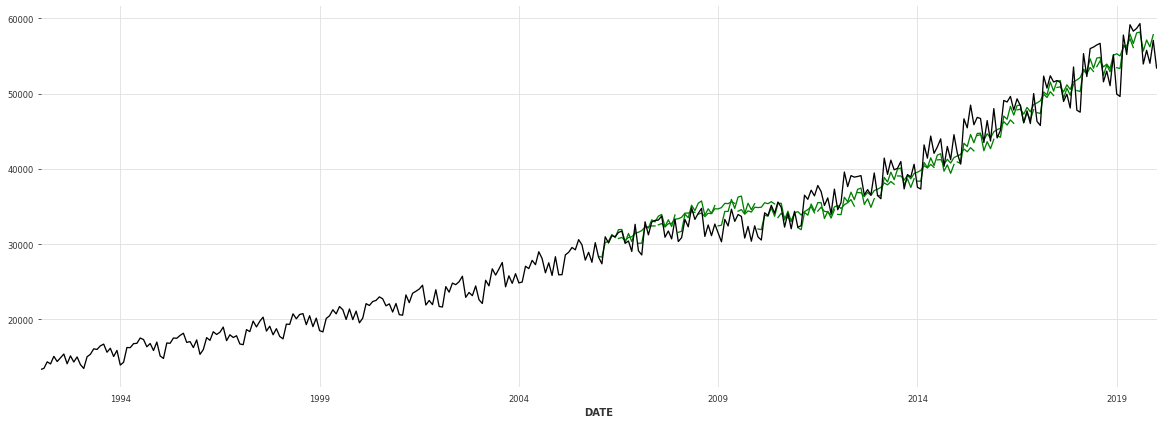

In [ ]:
plt.figure(figsize=(20,7))
for i in range(0,27):
  forecast3[i].plot(color='green')
series.plot(color='black')

In [ ]:
backtest_erros3 = model3.backtest(series, start=0.5, forecast_horizon=12, stride=1, last_points_only=False, metric=mape, reduction=None)

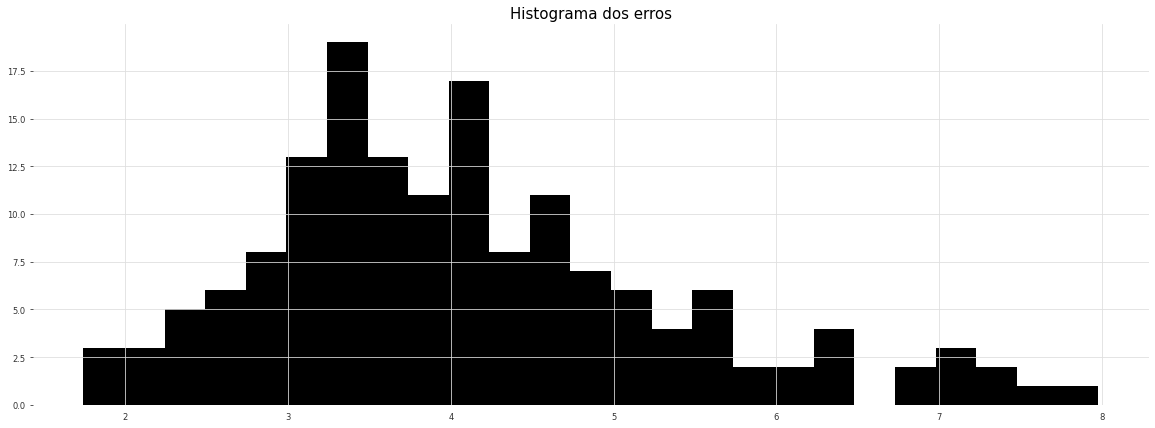

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Histograma dos erros', size=15)
plt.hist(backtest_erros3, bins=25);

Na análise dos resíduos do modelo: os erros estão flutuam em torno de zero, mas parece haver um comportamento sazonal e que é percebido, também, no gráfico *ACF*. A distribuição dos resíduos, conforme o histograma, não está centrada em zero e não possui um formato de sino, típico de uma distribuição normal.

/usr/local/lib/python3.6/dist-packages/darts/models/forecasting_model.py:247: RankWarning:

Polyfit may be poorly conditioned



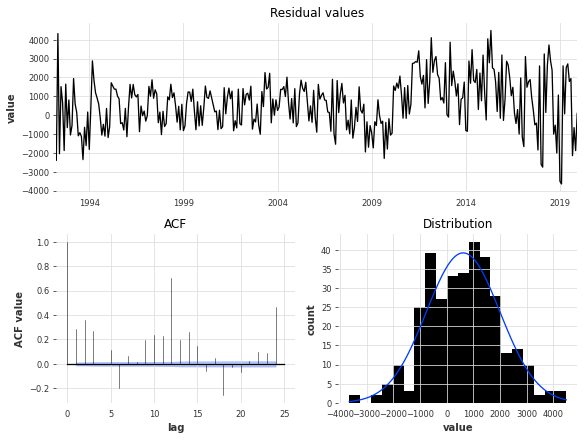

In [ ]:
plot_residuals_analysis(model3.residuals(series))

## Aplicando o  modelo *Four Theta*

Nesse modelo, que é uma variação dos modelos *Theta*, irei colocar como parâmetros *theta=0* (o modelo se restringe a uma regressão), com periodicidade de sazonalidade com 48 períodos, sazonalidade multiplicativa e tendência exponencial.

In [ ]:
#Instanciando o modelo em uma variável
model4 = FourTheta(theta = 0, seasonality_period=48, season_mode = SeasonalityMode.MULTIPLICATIVE, trend_mode=TrendMode.EXPONENTIAL)
#treinando o modelo
model4.fit(train)
#gerando as previsões e atribuindo uma variável para elas
prediction4 = model4.predict(len(val))

Imprimindo o modelo.

In [ ]:
print(model4)

4Theta(theta:0, curve:TrendMode.EXPONENTIAL, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE)


Plotando os valores preditos e os valores reais. A previsões acompanham bem os valores reais, mas os resultados são sempre menores que os valores reais; em alguns pontos eles chegam a coincidir.

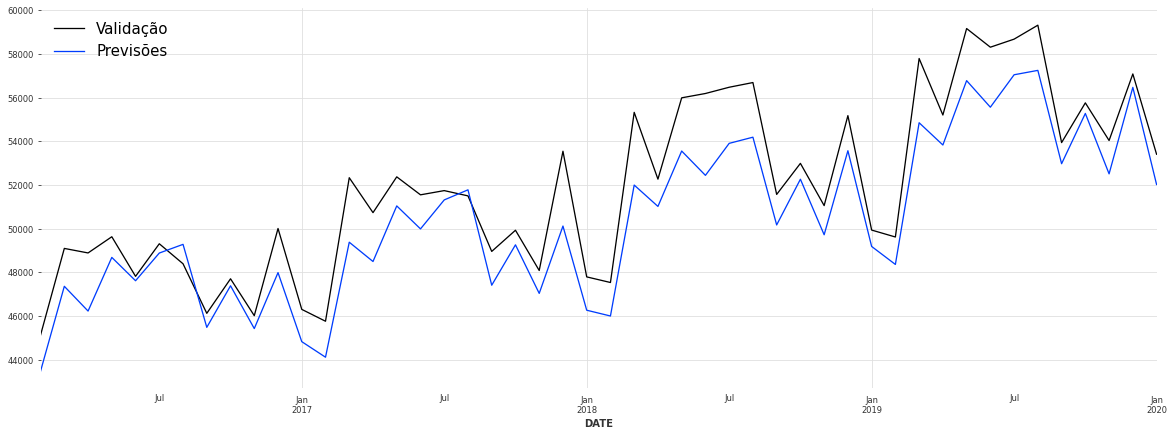

In [ ]:
plt.figure(figsize=(20,7))
#train.plot(label='Treino')
val.plot(label='Validação')
prediction4.plot(label='Previsões')
plt.legend(fontsize=15);

Métricas de avaliação do modelo *Four Theta*.

In [ ]:

print(tabulate([['Erro médio Absoluto percentual :', mape(prediction4, val)], 
                ['Coeficiente de variação :', coefficient_of_variation(prediction4, val)],
                ['Erro médio absoluto em escala :', mase(prediction4, val,insample = train)], 
                ['Erro médio absoluto :', mae(prediction4, val)],
                ['Erro médio quadrado :', mse(prediction4, val)],
                ['Raiz do erro médio quadrado :', rmse(prediction4, val)],
                ['Coeficiente de determinação R-Squared :', r2_score(prediction4, val)],
                ['Raiz do erro de log do quadrado médio :', rmsle(prediction4, val)],
                ['Erro percentual médio absoluto simétrico :', smape(prediction4, val)],
                ['Erro de porcentagem geral :', ope(prediction4, val)],
                ['Erro médio absoluto de alcance relativo :', marre(prediction4, val)]],     
               headers=['Métrica do modelo Four Theta', 'Valor']))

Métrica do modelo Four Theta                        Valor
------------------------------------------  -------------
Erro médio Absoluto percentual :               3.07563
Coeficiente de variação :                      3.5527
Erro médio absoluto em escala :                1.16594
Erro médio absoluto :                       1557.18
Erro médio quadrado :                          3.2082e+06
Raiz do erro médio quadrado :               1791.14
Coeficiente de determinação R-Squared :        0.750196
Raiz do erro de log do quadrado médio :        0.0343533
Erro percentual médio absoluto simétrico :     3.01601
Erro de porcentagem geral :                    2.99229
Erro médio absoluto de alcance relativo :     11.3131


Analisando o desempenho histórico do modelo *Four Theta*.

In [ ]:
forecast4 = model4.historical_forecasts(series, start=0.5, forecast_horizon=12, stride=6, last_points_only=False)

Plotando so resultados históricos, o modelo parece ter um bom desempenh histórico.

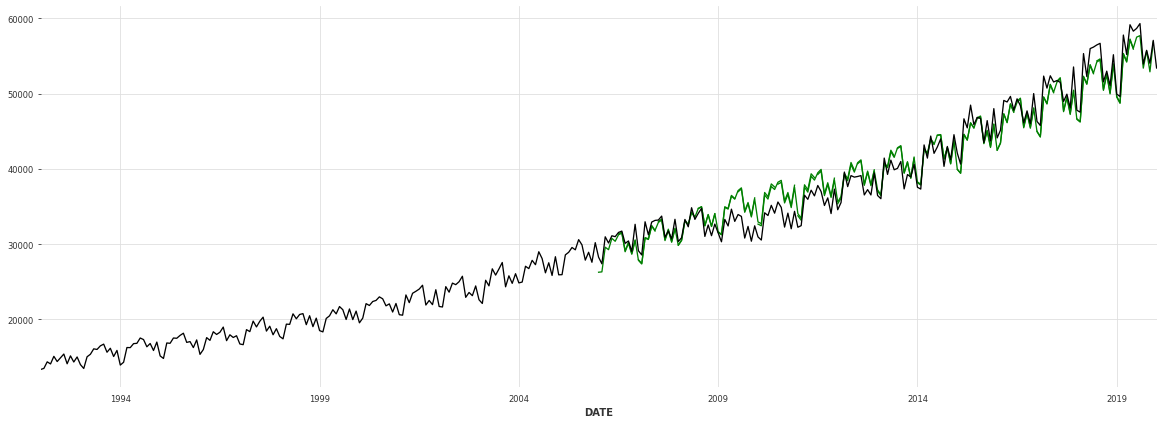

In [ ]:
plt.figure(figsize=(20,7))
for i in range(0,27):
  forecast4[i].plot(color='green')
series.plot(color='black')

Gerando os erros da modelagem histórica.

In [ ]:
backtest_erros4 = model4.backtest(series, start=0.5, forecast_horizon=12, stride=1, last_points_only=False, metric=mape, reduction=None)

Distribuição dos erros.

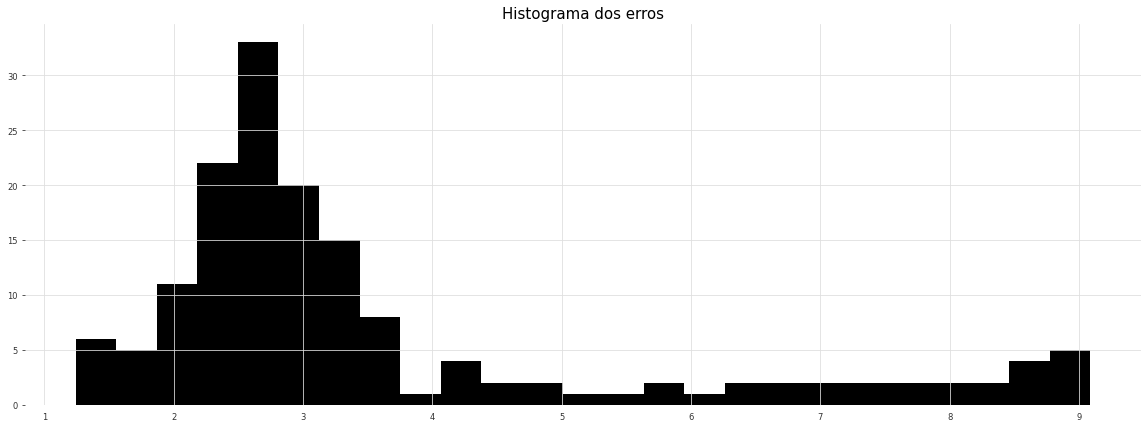

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Histograma dos erros', size=15)
plt.hist(backtest_erros4, bins=25);

## *Tuning* do modelo

Dado que o melhor modelo foi a Suavização Exponencial, podemos realizar uma pesquisa recursiva (*gridsearch*)  onde será realizada uma combinação de vários parâmetros desse modelo e verificar se o seu desempenho melhora ou não.

Abaixo irei criar um dicionário com os parâmetros e usarei a função *gridsearch*.



In [ ]:
parametros = {"trend":[ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE],
              "damped":[True, False],
              "seasonal":[ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE],
              "seasonal_periods":[12,24]}

Realizando o *gridseach*.

In [ ]:
ExponentialSmoothing().gridsearch(parameters=parametros,
                                  series=train, 
                                  forecast_horizon=len(val), 
                                  start=0.5, 
                                  last_points_only=False,
                                  metric=r2_score, 
                                  reduction=np.mean)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimizati

(<darts.models.exponential_smoothing.ExponentialSmoothing at 0x7f8bab50a208>,
 {'damped': True,
  'seasonal': <ModelMode.MULTIPLICATIVE: 'multiplicative'>,
  'seasonal_periods': 24,
  'trend': <ModelMode.ADDITIVE: 'additive'>})

O melhor modelo, conforme podemos ver acima foi o 

**ExponentialSmoothing( damped= True, seasonal=ModelMode.MULTIPLICATIVE, seasonal_periods= 24, trend=ModelMode.ADDITIVE )**

Assim irei criar esse modelo e gerar as previsões.

In [ ]:
#Instanciando o modelo em uma variável
model_grid = ExponentialSmoothing(damped= True, seasonal=ModelMode.MULTIPLICATIVE, seasonal_periods= 24, trend=ModelMode.ADDITIVE)
#treinando o modelo
model_grid.fit(train)
#gerando as previsões e atribuindo uma variável para elas
prediction_grid = model_grid.predict(len(val))

Imprimindo o modelo.

In [ ]:
print(model_grid)

Exponential smoothing


Plotando as previsões do modelo *tunado*, modelo original e os valores reais.

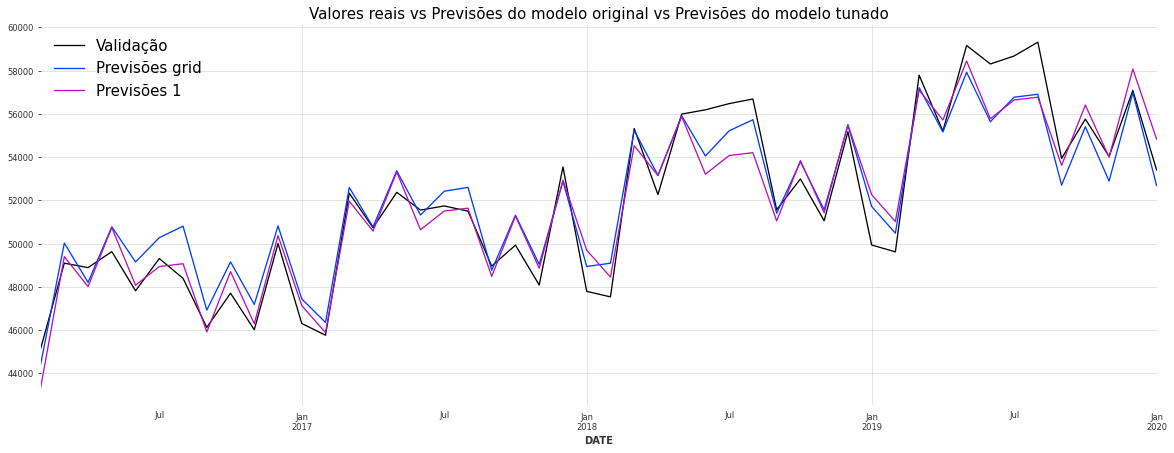

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Valores reais vs Previsões do modelo original vs Previsões do modelo tunado', size=15)
val.plot(label='Validação')
prediction_grid.plot(label='Previsões grid')
prediction1.plot(label='Previsões 1')
plt.legend(fontsize=15);

Temos onze (11) métricas de avaliação, em 2 delas o modelo *tunado* obteve um desempenho melhor que o modelo de Suavização Exponencial original, que foram o *MSE* e o *RMSE*. Essas métricas (mesmo que redundante) são as mais usadas para problemas de séries temporais, se considerarmos apenas essas métricas, então o *tuning* foi bem sucedido.

Considerando as outras métricas, o modelo original é melhor. 

In [ ]:
print(tabulate([['Erro médio Absoluto percentual :', mape(prediction1, val), mape(prediction_grid, val)], 
                ['Coeficiente de variação :', coefficient_of_variation(prediction1, val), coefficient_of_variation(prediction_grid, val)],
                ['Erro médio absoluto em escala :', mase(prediction1, val,insample = train), mase(prediction_grid, val,insample = train)], 
                ['Erro médio absoluto :', mae(prediction1, val), mae(prediction_grid, val)],
                ['Erro médio quadrado :', mse(prediction1, val), mse(prediction_grid, val)],
                ['Raiz do erro médio quadrado :', rmse(prediction1, val), rmse(prediction_grid, val)],
                ['Coeficiente de determinação R-Squared :', r2_score(prediction1, val), r2_score(prediction_grid, val)],
                ['Raiz do erro de log do quadrado médio :', rmsle(prediction1, val), rmsle(prediction_grid, val)],
                ['Erro percentual médio absoluto simétrico :', smape(prediction1, val), smape(prediction_grid, val)],
                ['Erro de porcentagem geral :', ope(prediction1, val), ope(prediction_grid, val)],
                ['Erro médio absoluto de alcance relativo :', marre(prediction1, val), marre(prediction_grid, val)]],     
               headers=['Métrica dos modelos', 'Suavização Exponencial','Suavização Exponencial Tuning']))

Métrica dos modelos                           Suavização Exponencial    Suavização Exponencial Tuning
------------------------------------------  ------------------------  -------------------------------
Erro médio Absoluto percentual :                         1.78747                          1.82779
Coeficiente de variação :                                2.3298                           2.19491
Erro médio absoluto em escala :                          0.699859                         0.71094
Erro médio absoluto :                                  934.696                          949.496
Erro médio quadrado :                                    1.45938e+06                      1.30565e+06
Raiz do erro médio quadrado :                         1208.05                          1142.65
Coeficiente de determinação R-Squared :                  0.880373                         0.871605
Raiz do erro de log do quadrado médio :                  0.0227252                        0.0218175
Erro perce

## Conclusão

Como pode ser visto nesse projeto a biblioteca *DARTS* é simples, prática e fácil de manejar, além de possuir vários modelos de séries temporais que podem ser implementados sem nenhuma dificuldade. O melhor modelo que obtivemos foi o de Suavização exponencial, comparação com outros modelos. Esse é um dos projetos que utilizarei a bilioteca *DARTS*, em um outro projeto irei explorar os modelos de Redes Neurais (Recorrentes e Convolucionais) com outra base de dados.